In [2]:
%pip install statsmodels
%pip install holidays

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Vitor\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Vitor\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')

import sys

# Bibliteca para Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para Manipulação de Dados
import pandas as pd
import numpy as np

# Biblioteca para Análise e modelagem de séries temporais
from statsmodels.tsa.seasonal import seasonal_decompose

# Imports para formatação dos gráficos
import matplotlib.cbook
import matplotlib as m
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

# Imports para criação e validação dos modelos temporais
from statsmodels.tsa.arima_model import ARIMA
import sklearn
from sklearn.metrics import mean_squared_error 
import itertools

# Import para Padronização dos dados
from sklearn.preprocessing import StandardScaler

# Import utilizado para Feature Selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

# Import utilizado para análise de MultiColinearidade dos Dados
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import para Análise de Estacionaridade nos Modelos de Séries Temporais
from statsmodels.tsa.stattools import adfuller

# Import para obter os feriados usados no Modelo SARIMAX Exógeno
import holidays

# Import Modelo de Séries Temporais Multivariado
from statsmodels.tsa.vector_ar.var_model import VAR

# Imports para o modelo Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# Import para aplicar Cross Validation
from sklearn.model_selection import cross_val_score

# Import para definir os KFold do CV
from sklearn.model_selection import RepeatedKFold

# Import para Otimização de HiperParametros
from sklearn.model_selection import GridSearchCV

# Import para o modelo de Regressão Linear
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
matplotlib.style.use('ggplot')

%matplotlib inline

In [4]:
import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
# Import Dataset de Treino.
df_train = pd.read_csv('data/dataset_training.csv')
df_test = pd.read_csv('data/dataset_testing.csv')

In [6]:
# Unificando o df_train e df_test pois lá na frente iremos utilizar séries temporais e os dados a serem previstos 
# devem ser os mais atuais possível.
df_full = pd.concat([df_train, df_test])
df_full = df_full.sort_values(['date'], ascending=True)
df_full.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
0,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,63000,Weekday,Monday
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday


In [7]:
# juda para exibir os dados de forma mais compacta
# corrir erro: pd.set_option('display.max_colwidth', 1000)
#pd não foi definido, então vamos definir as opções de exibição do 


pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Análise Exploratória

In [8]:
df_train.shape

(14803, 32)

In [9]:
df_test.shape

(4932, 32)

In [10]:
df_full.shape

(19735, 32)

T > Temperatura

RH > Umidade Relativa (Relative Humidity)

T_out > Temperatura do lado de fora da casa

RH_out > Umidade do lado de fora da casa

mm_hg > Unidade de pressão

In [11]:
# Considerando a variável rv1 como a TARGET do dataset
column_target = 'rv1'

In [12]:
# Analisando as informações de cada dado
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 0 to 14802
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9       

In [13]:
# Resumo estatístico dos dados
df_full.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,42907.129465
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,24940.020831
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,21600.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,43200.000000
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,64200.000000
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,85800.000000


In [14]:
def formata_dados(dataset):
    # Convertendo a coluna date para o formato DateTime
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d %H:%M:%S')
     
    # Aplicando o Split de alguns dados do campo Date  Obs.: O Campo Day_of_week vai ser transformado em inteiro.
    dataset['Month'] = dataset['date'].dt.month
    dataset['day'] = dataset['date'].dt.day
    dataset['hour'] = dataset['date'].dt.hour
    dataset['Day_of_week'] = dataset['date'].dt.dayofweek

    # Renomeando a variável WeekStatus para Weekend. Essa variável terá valores 0 e 1. {0 : Weekday , 1: Weekend}
    dataset.rename(columns={'WeekStatus':'Weekend'}, inplace=True)

    # Segunda Feira = 0 ... Sabado = 5, Domingo = 6
    dataset['Weekend'] = 0
    dataset.loc[(dataset.Day_of_week == 5) | (dataset.Day_of_week == 6), 'Weekend'] = 1    
    
    # Padronizando o nome das colunas para Lower
    dataset.columns = map(str.lower, dataset.columns)
    
    return dataset

In [15]:
df_train = formata_dados(df_train)
df_test = formata_dados(df_test)
df_full = formata_dados(df_full)

In [16]:
df_full.columns 

Index(['date', 'appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4', 'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9', 'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility', 'tdewpoint', 'rv1', 'rv2', 'nsm', 'weekend', 'day_of_week', 'month', 'day', 'hour'], dtype='object')

In [17]:
df_full.head(5)

,date,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,t5,rh_5,t6,rh_6,t7,rh_7,t8,rh_8,t9,rh_9,t_out,press_mm_hg,rh_out,windspeed,visibility,tdewpoint,rv1,rv2,nsm,weekend,day_of_week,month,day,hour
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,0,0,1,11,17
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,0,0,1,11,17
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,0,0,1,11,17
0,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,63000,0,0,1,11,17
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,0,0,1,11,17


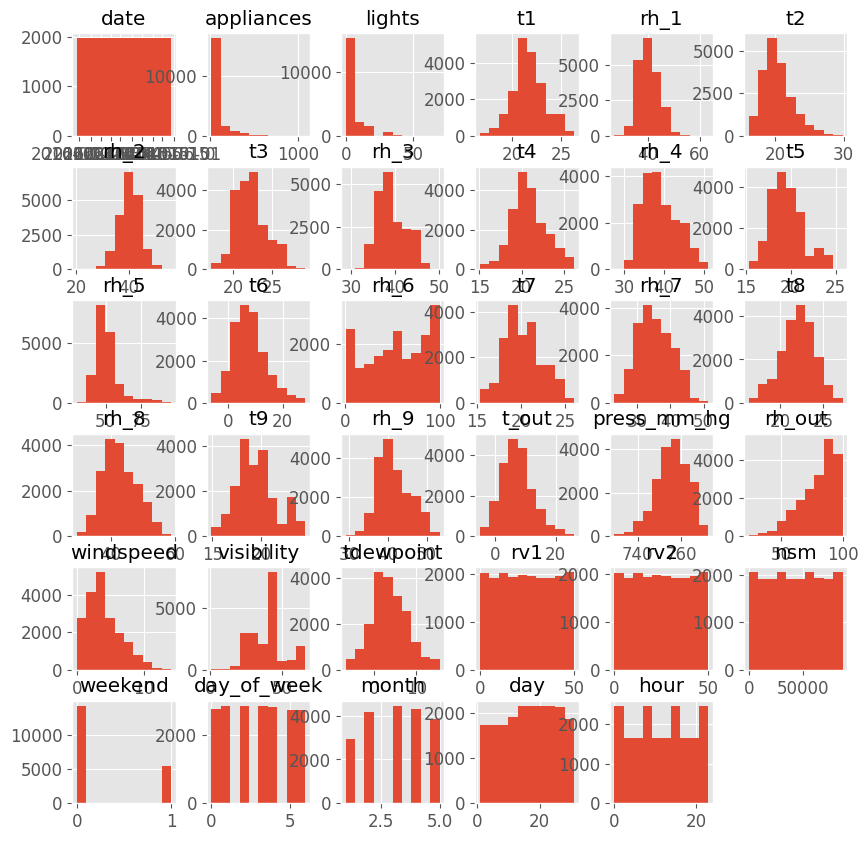

In [18]:
df_full.hist(figsize=(10,10));

Text(0.5, 0, '0: Dia útil / 1: Final de Semana')

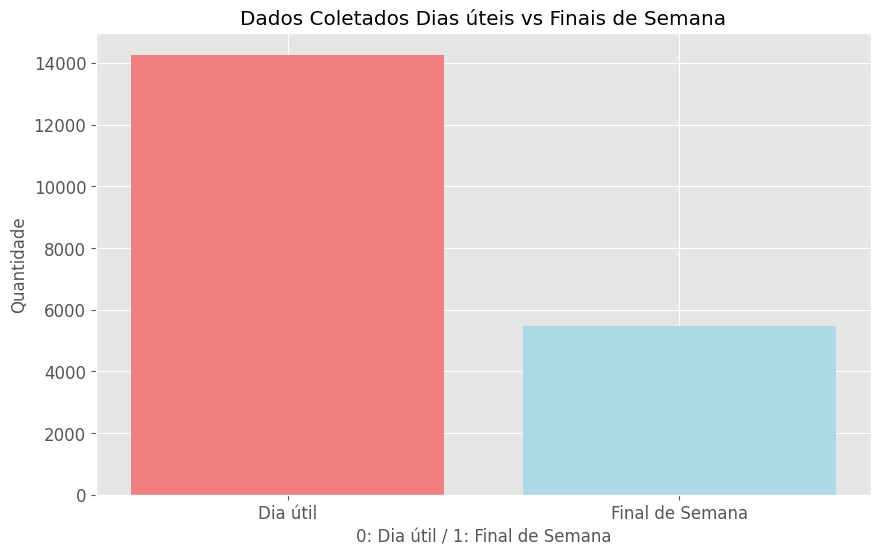

In [ ]:
# Quantidade de dados coletados Weekend e WeekDay
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (10,6))
# Calculando a quantidade de dados por classe
counts = df_full['weekend'].value_counts().sort_index()

# Plotando gráfico de barras customizado
ax.bar(['Weekday', 'Weekend'], counts, color=['lightcoral', 'lightblue'])
ax.set_title('Dados Coletados Dias úteis vs Finais de Semana')
ax.set_ylabel('Quantidade')
ax.set_xticklabels(['Dia útil', 'Final de Semana'])
ax.set_xlabel('0: Dia útil / 1: Final de Semana')

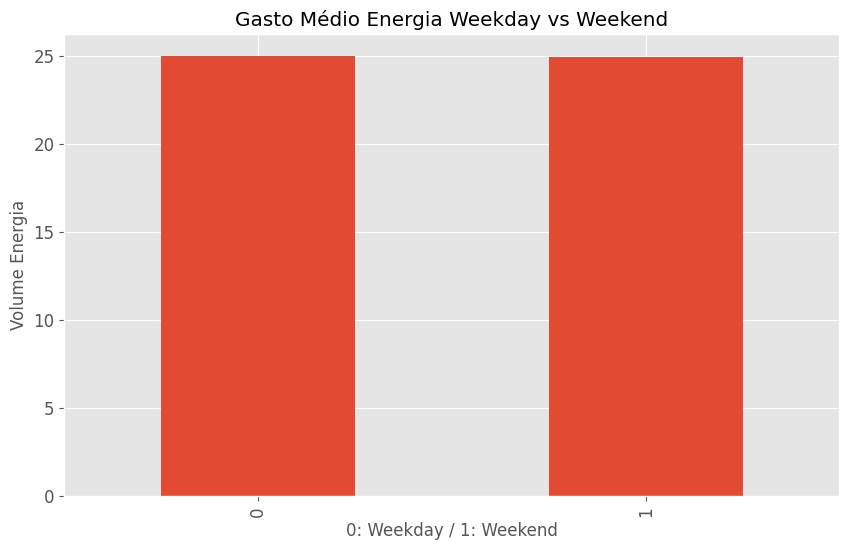

In [20]:
fig, ax = plt.subplots(figsize = (10,6))

df_full.groupby('weekend').mean()[column_target].plot(kind='bar')

ax.set_title('Gasto Médio Energia Weekday vs Weekend')
ax.set_ylabel('Volume Energia')
ax.set_xlabel('0: Weekday / 1: Weekend');

In [21]:
df_full.groupby('day_of_week').mean()[column_target]


day_of_week
0    24.337311
1    25.106401
2    25.294359
3    24.966591
4    25.247644
5    25.055579
6    24.886771
Name: rv1, dtype: float64

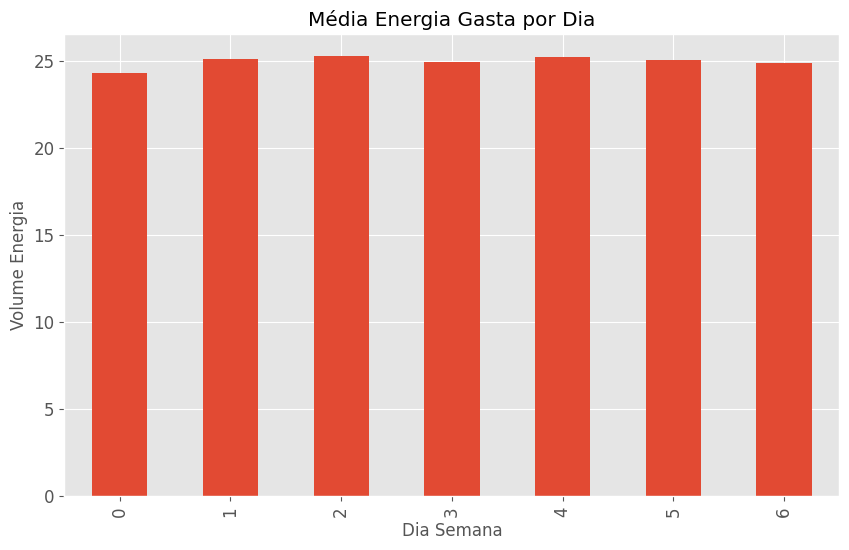

In [22]:
fig, ax = plt.subplots(figsize = (10,6))

df_full.groupby('day_of_week').mean()[column_target].plot(kind='bar')

ax.set_title('Média Energia Gasta por Dia')
ax.set_ylabel('Volume Energia')
ax.set_xlabel('Dia Semana');

O Gasto médio de energia no FDS e em dias de semana representam o mesmo gasto. Tomando como base que possui 5 dias Weekday e apenas 2 Weekend, o gasto nos FDS são relativamente maiores baseado na proporção da distribuição dos dados.



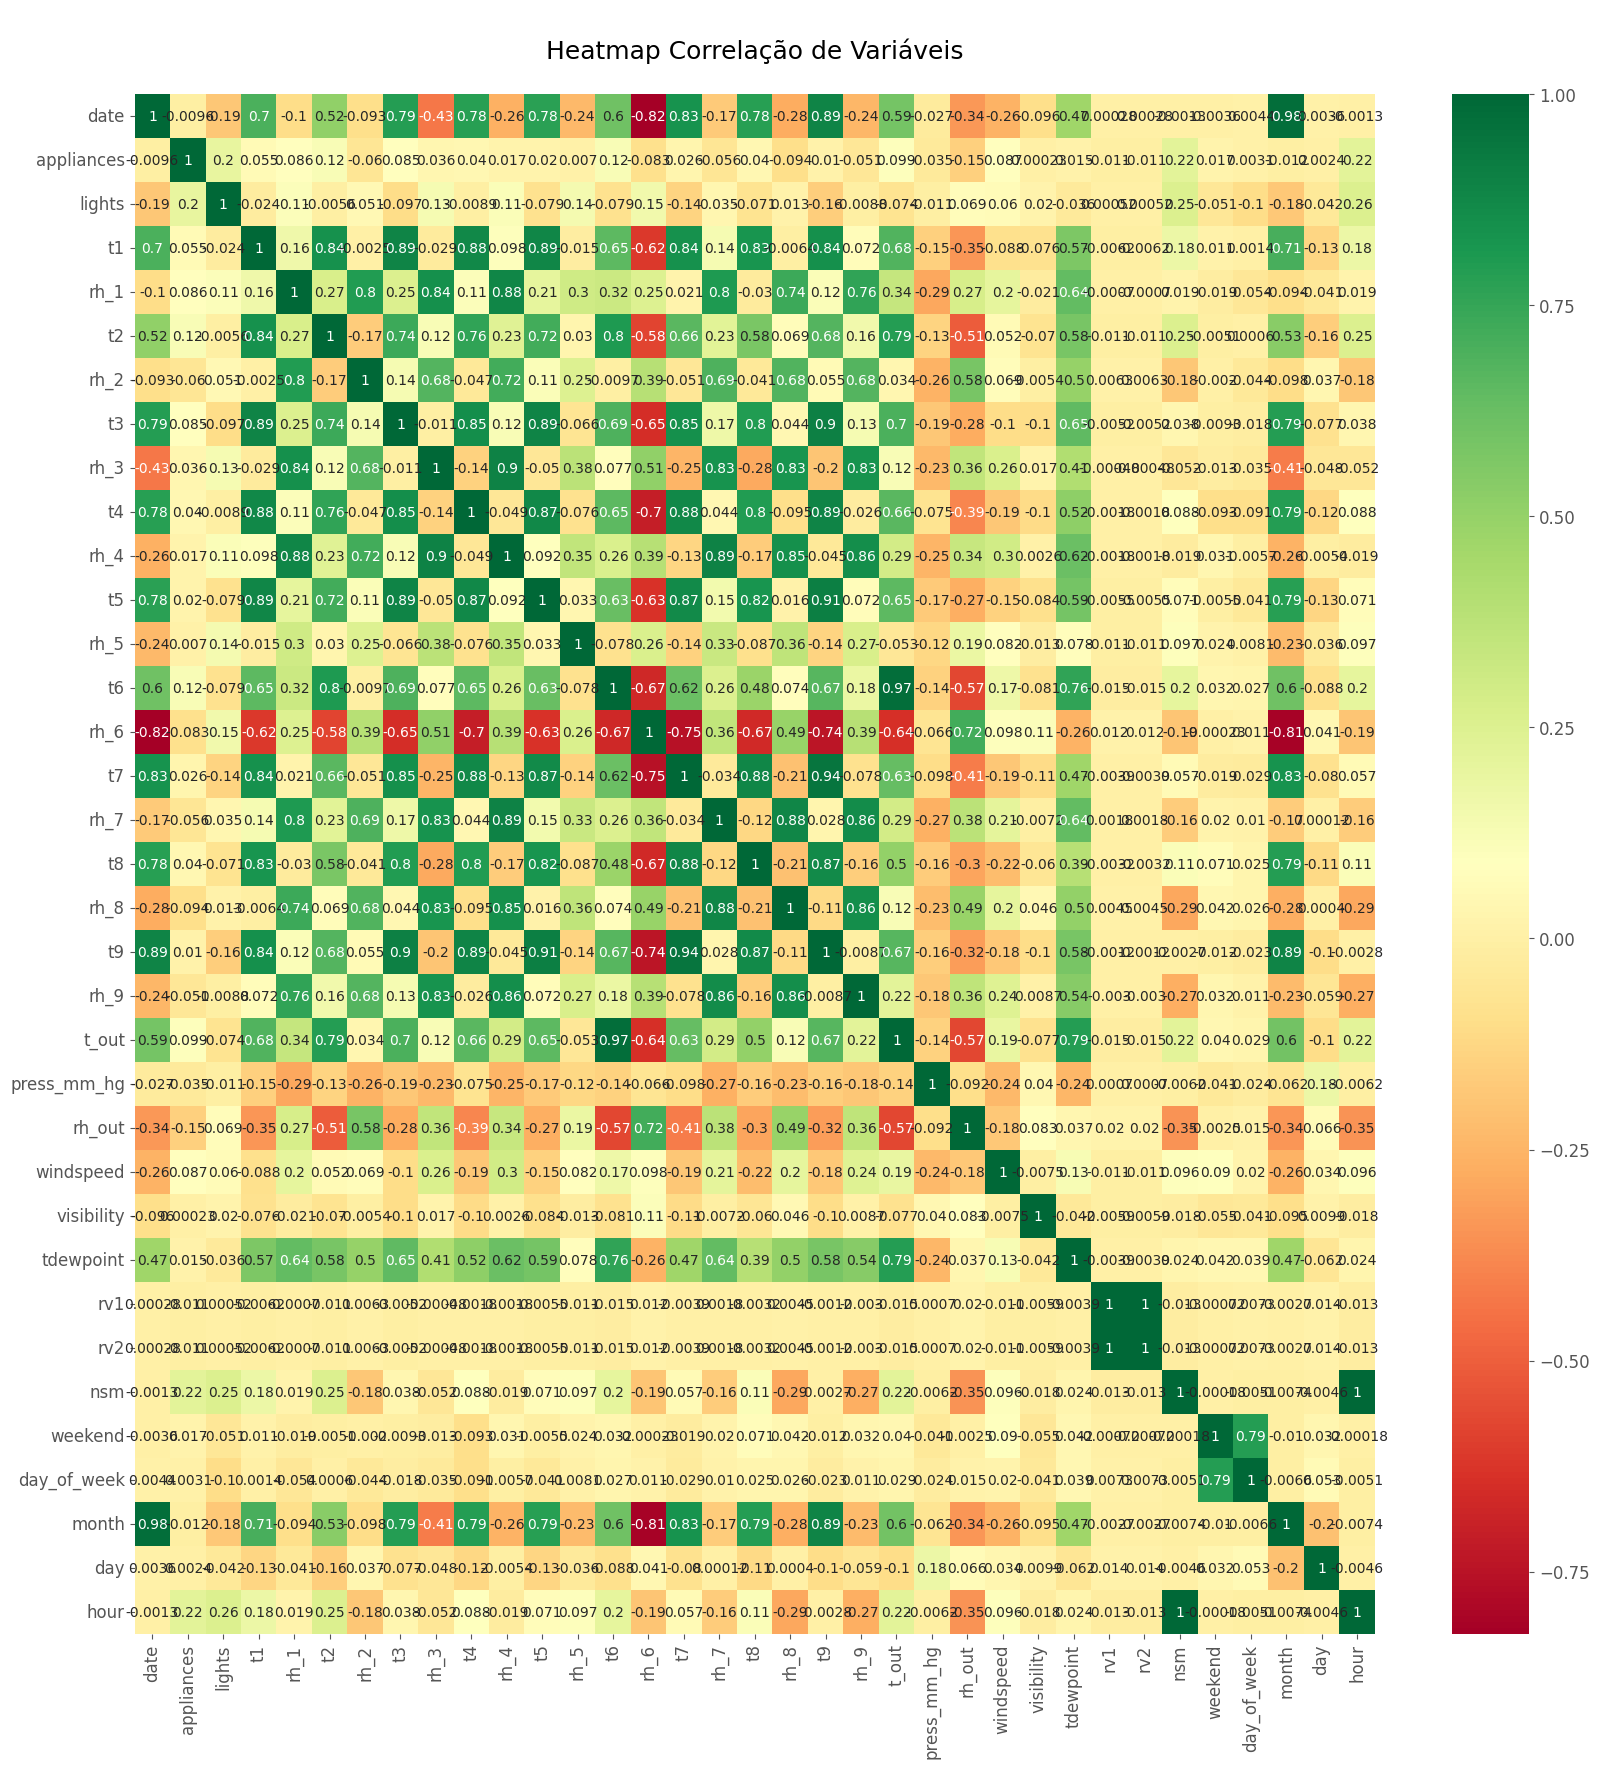

In [23]:
corrmat = df_full.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(20,20))
plt.title('\nHeatmap Correlação de Variáveis\n', fontsize=18)

g=sns.heatmap(df_full[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [24]:
# Variavel nsm e hour são altamente correlacionadas. Drop Coluna Hour.
df_train.drop('hour', axis=1, inplace=True)
df_test.drop('hour', axis=1, inplace=True)
df_full.drop('hour', axis=1, inplace=True)

In [25]:
# Variavel rv1 e rv2 são altamente correlacionadas e possuem a mesma informação. Vamos Dropar uma das colunas.
df_train.drop('rv2', axis=1, inplace=True)
df_test.drop('rv2', axis=1, inplace=True)
df_full.drop('rv2', axis=1, inplace=True)

In [26]:
# Definindo a variavel date como Index do Dataset. 
# Essa operação transforma os dados em séries possibilitando a análise como Series Temporais.
df_full.index = df_full['date']
df_full = df_full.drop('date',1)
df_full.head(5)

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
df_train.index = df_train['date']
df_train = df_train.drop('date', 1)

df_test.index = df_test['date']
df_test = df_test.drop('date', 1)

### Seleção de Atributos com Random Forest